# Compare offline turbulence to observations
### Bias between observed and offline simulated turbulence

In [1]:
# -------------------------------------------------------------------------------------------------------
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
from string import ascii_lowercase

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc

## Directories

In [2]:
# Project directory
dir_proj = '/Users/karllapo/proj/SnowHydro_OfflineTurb'
dir_print = os.path.join(dir_proj, 'graphics')

# Data
dir_data = os.path.join(dir_proj, 'data')
dir_snq = os.path.join(dir_data, 'SNQ')
dir_scp = os.path.join(dir_data, 'SCP')

# Model output
dir_model_ouptut = os.path.join(dir_data, 'results')

## Plot customization

In [3]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']

# This is only relevant if you have a retina screen
%config InlineBackend.figure_format = 'retina'

### Surface observations

In [4]:
# -------------------------------------------------------------------------------------------------------
# SNQ
os.chdir(dir_snq)
snq = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

# Indices of simulated turbulence times (observations exist, wind > 2m/s, snow is present)
ribulk = turbpy.bulkRichardson(snq.T6 + 273.15 + 0.06, snq.Tsrf + 273.15, snq.WIND, 6 - snq.Snowdepth)
snq_ind = ribulk > 0

# -------------------------------------------------------------------------------------------------------
# SCP
os.chdir(dir_scp)
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
scp = xr.open_dataset('SCP.Mtower_pottemps.nc')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# Turbulence
scp['obs_qh_2m'] = fluxObs.w_tc__2m_M
scp['obs_qh_10m'] = fluxObs.w_tc__10m_M

# Indices of stable periods
ri = turbpy.bulkRichardson(scp['theta_10m'] + 273.15, scp['Tsfc'] + 273.15, scp['UBar_10m'], 10.)
scp['RiBulk_10m'] = (('time'), ri)
scp_ind_10m = np.nonzero((scp.RiBulk_10m > 0.).values)

ri = turbpy.bulkRichardson(scp['theta_2m'] + 273.15, scp['Tsfc'] + 273.15, scp['UBar_2m'], 2.)
scp['RiBulk_2m'] = (('time'), ri)
scp_ind_2m = np.nonzero((scp.RiBulk_2m > 0.).values)

In [5]:
# Set up the parameters for running turbpy
stab_titles = ('Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              )

axis_titles = {'Standard': 'log-linear (Ri)',
               'Louis (b = 4.7)': ' Louis',
               'Louis (b = 12)': 'Louis (modified)',
               'Louis (Ri capped, MJ98)': 'Louis (capped)',
               'MO (Holtslag/de Bruin)': 'HD88',
               'MO (Holtslag/de Bruin - capped)': 'HD88 (capped)',
               'MO (Beljaars/Holtslag)': 'BH91',
               'MO (Webb - NoahMP)': 'Webb (NoahMPv1.1)',
               'MO (Cheng/Brutsaert)': 'CB05',}

# Titles for output and xarray datasets
out_titles = {'Standard': 'standard',
               'Louis (b = 4.7)': 'louis',
               'Louis (b = 12)': 'louis_mod',
               'Louis (Ri capped, MJ98)': 'louis_cap',
               'MO (Holtslag/de Bruin)': 'HD88',
               'MO (Holtslag/de Bruin - capped)': 'HD88_cap',
               'MO (Beljaars/Holtslag)': 'BJ91',
               'MO (Webb - NoahMP)': 'webb_noah',
               'MO (Cheng/Brutsaert)': 'CB05',
             }

stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

## Offline Turbulence results

#### SCP
- Run in the script TF.SUMMATurbConversion_SCP.py script on j-lundquist-3
- Results saved to OfflineTurb.SCP.sensible_1m.ALL.nc. The "ALL" refers to doing offline simulations on all stable conditions, instead of just a 5% sample, as in previous iterations.
- The criteria for stable conditions comes from the 15m observations

#### SNQ
- Simulation run in TF.OfflineTurb.SNQ
- the resulting netcdf was copied from the SNQ data directory to the project level directory. Re-running the script won't change the results in this script unless explicitly moved again.
- Simulations only run for periods of wind > 2m/s

In [6]:
os.chdir(dir_model_ouptut)
z0assumption = 'constant_small_z0'

# -------------------------------------------------------------------------------------------------------
# SNQ Offline Turbulence results
snq_qh = xr.open_dataset('TF.SNQ.sensible_revisions.' + z0assumption + '.nc')

# -------------------------------------------------------------------------------------------------------
# SCP Offline Turbulence results
scp_2m = xr.open_dataset('TF.SCP.sensible_2m_revision.' + z0assumption + '.nc')
scp_10m = xr.open_dataset('TF.SCP.sensible_10m_revision.' + z0assumption + '.nc')

### Compare offline turb to observed turb

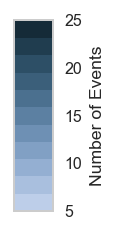

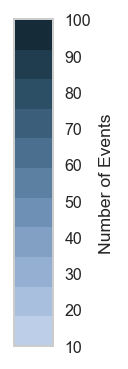

In [7]:
os.chdir(dir_print)

## General colorbar arguments
cmin = 10
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Colorbar for Snoqualmie
bounds = [5, 10, 15, 20, 25]
fig, caxi = plt.subplots(1, 1, figsize=(.35, 1.75))
# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
norm = matplotlib.colors.Normalize(vmin=5, vmax=25)
cbar = matplotlib.colorbar.ColorbarBase(caxi, cmap=cmap, norm=norm, orientation='vertical', ticks=bounds)

# cbar = plt.colorbar(im, cax=caxi, orientation="vertical", spacing='proportional')
cbar.ax.set_ylabel('Number of Events')
fig.savefig('OfflineTurb.2dHist.Colorbar.SNQ.' + context + '.pdf', bbox_inches='tight')

# Colorbar for the Shallow Cold Pool
fig, caxi = plt.subplots(1, 1, figsize=(.35, 3))
# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
norm = matplotlib.colors.Normalize(vmin=cmin, vmax=cmax)
cbar = matplotlib.colorbar.ColorbarBase(caxi, cmap=cmap, norm=norm, orientation='vertical')

# cbar = plt.colorbar(im, cax=caxi, orientation="vertical", spacing='proportional')
cbar.ax.set_ylabel('Number of Events')
fig.savefig('OfflineTurb.2dHist.Colorbar.SCP.' + context + '.pdf', bbox_inches='tight')

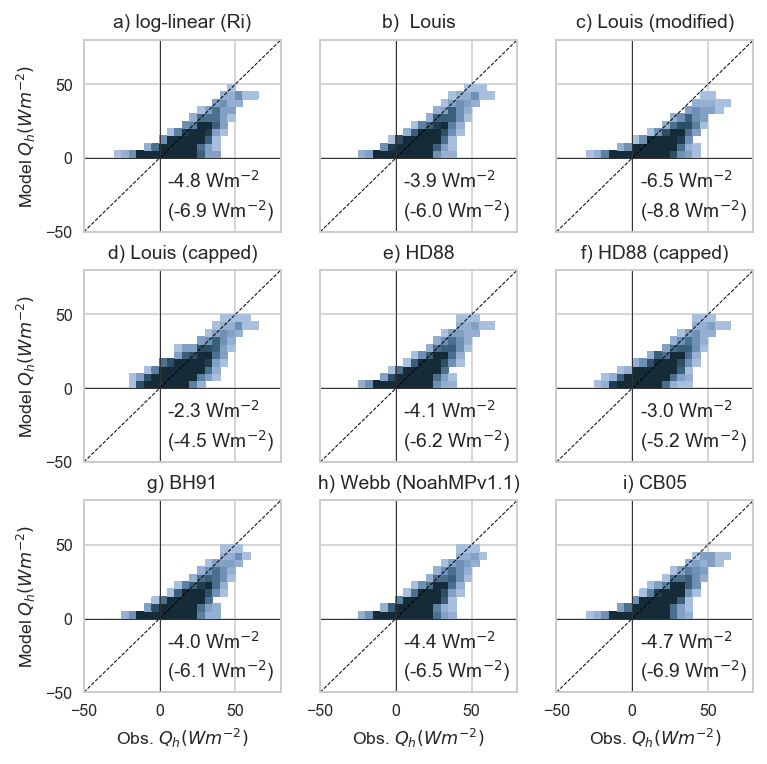

In [8]:
os.chdir(dir_print)

# -------------------------------------------------------------------------------------------------------
# SCP - 2m
ymin = -50
ymax = 80
dx = 5
xmin = ymin
xmax = ymax
dy = dx

# Format figure
if 'paper' in context:
    fig, axes = plt.subplots(3, 3, figsize=(6, 6), sharex='col', sharey='row')
    textLoc = 5
else:
    fig, axes = plt.subplots(2, 5, figsize=(12.5, 3), sharex='col', sharey='row')
    textLoc = 30
axes = axes.flatten()

# Observed turbulence at 2m
for ix, stab in enumerate(stab_titles):
    ax = axes[ix]
    method = out_titles[stab]
    
    # Build my own histogram
    X = -scp.obs_qh_2m[scp_ind_2m].values.flatten()
    Y = scp_2m[method].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                                   np.arange(ymin, ymax, dy)))
    H = np.ma.masked_array(H, H < cmin+dcol)

    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    
    # Zero lines
    ax.plot([xmin, xmax], [ymin, ymax], 'k--', linewidth=.5)
    ax.plot([0, 0], [ymin, ymax], linewidth=0.5, color='.2')
    ax.plot([xmin, xmax], [0, 0], linewidth=0.5, color='.2')

    # Format
    ax.set_title(ascii_lowercase[ix] + ") " + axis_titles[stab])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    if ax.is_last_row():
        ax.set_xlabel('Obs. $Q_h (Wm^{-2})$')
    if ax.is_first_col():
        ax.set_ylabel('Model $Q_h (Wm^{-2})$')
    ax.grid()

    # Bias
    bias = np.nanmean(scp_2m[method] + scp.obs_qh_2m[scp_ind_2m])
    
    # Bias, removing counter gradient fluxes
    temp_obs = -scp.obs_qh_2m[scp_ind_2m]
    temp_obs[temp_obs < 0] = np.nan
    bias_nocg = np.nanmean(scp_2m[method] - temp_obs)
    
    ax.text(textLoc, -20, '%2.1f' % bias + ' Wm$^{-2}$')
    ax.text(textLoc, -40, '(%2.1f' % bias_nocg + ' Wm$^{-2}$)')

fig.savefig('2dHist_Bias.SCP_2m.' + context + '.' + z0assumption + '.pdf', bbox_inches='tight', dpi=300)

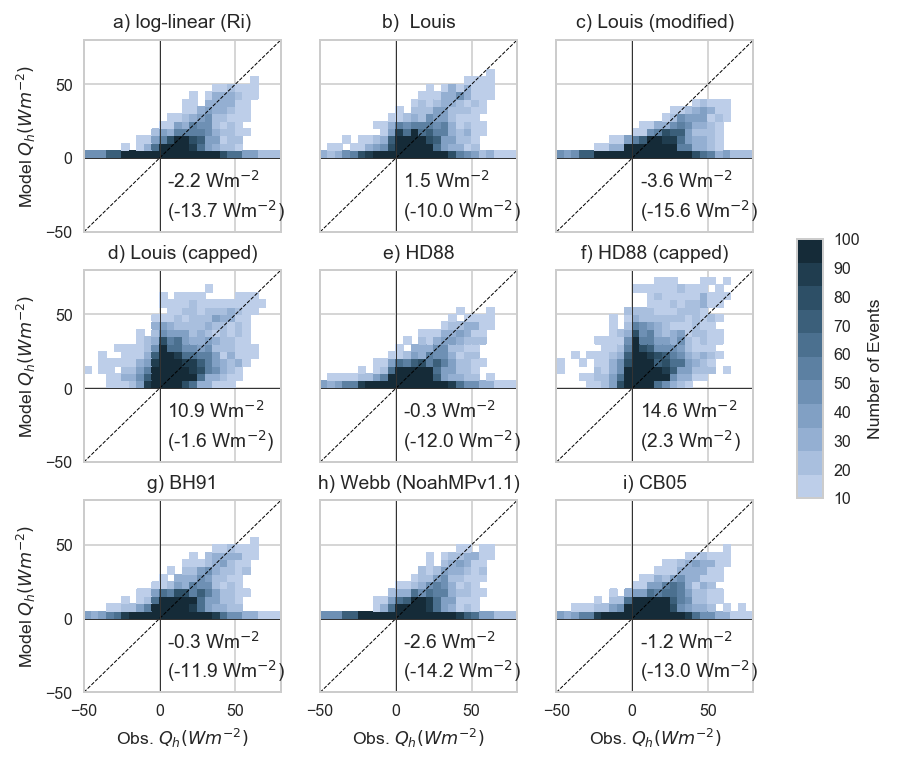

In [9]:
os.chdir(dir_print)

# -------------------------------------------------------------------------------------------------------
# SCP - 10m
ymin = -50
ymax = 80
dx = 5
xmin = ymin
xmax = ymax
dy = dx

# Colorbar
cmin = 10
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Format figure
if 'paper' in context:
    fig, axes = plt.subplots(3, 3, figsize=(6, 6), sharex='col', sharey='row')
    textLoc = 5
else:
    fig, axes = plt.subplots(2, 5, figsize=(12.5, 3), sharex='col', sharey='row')
    textLoc = 30
axes = axes.flatten()

for ix, stab in enumerate(stab_titles):
    ax = axes[ix]
    method = out_titles[stab]
    
    # Build my own histogram
    X = -scp.obs_qh_10m[scp_ind_10m].values.flatten()
    Y = scp_10m[method].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                                   np.arange(ymin, ymax + dy, dy)))
    H = np.ma.masked_array(H, H < cmin)

    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    
    # Zero lines
    ax.plot([xmin, xmax], [ymin, ymax], 'k--', linewidth=.5)
    ax.plot([0, 0], [ymin, ymax], linewidth=0.5, color='.2')
    ax.plot([xmin, xmax], [0, 0], linewidth=0.5, color='.2')

    # Format
    ax.set_title(ascii_lowercase[ix] + ") " + axis_titles[stab])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    if ax.is_last_row():
        ax.set_xlabel('Obs. $Q_h (Wm^{-2})$')
    if ax.is_first_col():
        ax.set_ylabel('Model $Q_h (Wm^{-2})$')
    ax.grid()

    # Bias
    bias = np.nanmean(scp_10m[method] + scp.obs_qh_10m[scp_ind_10m])
    
    # Bias, removing counter gradient fluxes
    temp_obs = -scp.obs_qh_10m[scp_ind_10m]
    temp_obs[temp_obs < 0] = np.nan
    bias_nocg = np.nanmean(scp_10m[method] - temp_obs)
    
    ax.text(textLoc, -20, '%2.1f' % bias + ' Wm$^{-2}$')
    ax.text(textLoc, -40, '(%2.1f' % bias_nocg + ' Wm$^{-2}$)')

## Add the colorbar
cax = fig.add_axes([0.95, 0.35, 0.03, 0.3])
norm = matplotlib.colors.Normalize(vmin=cmin, vmax=cmax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.ax.set_ylabel('Number of Events')

fig.savefig('2dHist_Bias.SCP_10m.' + context + '.' + z0assumption + '.pdf', bbox_inches='tight', dpi=300)


/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


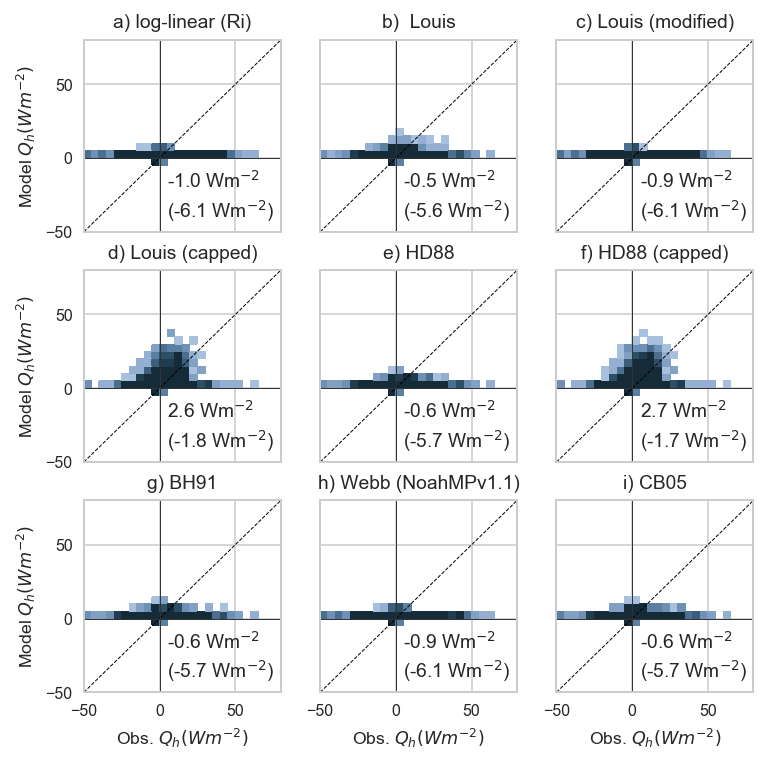

In [10]:
os.chdir(dir_print)

# -------------------------------------------------------------------------------------------------------
# SNQ
ymin = -50
ymax = 80
dy = 5
xmin = ymin
xmax = ymax
dx = dy

cmin = 5
cmax = 25
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)

# Format figure
if 'paper' in context:
    fig, axes = plt.subplots(3, 3, figsize=(6, 6), sharex='col', sharey='row')
    textLoc = 5
else:
    fig, axes = plt.subplots(2, 5, figsize=(12.5, 3), sharex='col', sharey='row')
    textLoc = 30
axes = axes.flatten()

# Simulated turbulence
for ix, stab in enumerate(stab_titles):
    ax = axes[ix]
    method = out_titles[stab]
    
    # Build my own histogram
    X = snq.SensFlux[snq_ind].values.flatten()
    Y = snq_qh[method].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                                   np.arange(ymin, ymax + dy, dy)))
    H = np.ma.masked_array(H, H < cmin+dcol)
    
    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    
    # One to one line
    ax.plot([xmin, xmax], [ymin, ymax], 'k--', linewidth=.5)

    # zero lines
    ax.plot([0, 0], [ymin, ymax], linewidth=0.5, color='.2')
    ax.plot([xmin, xmax], [0, 0], linewidth=0.5, color='.2')
    
    # Formatting
    ax.set_title(ascii_lowercase[ix] + ") " + axis_titles[stab])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    if ax.is_last_row():
        ax.set_xlabel('Obs. $Q_h (Wm^{-2})$')
    if ax.is_first_col():
        ax.set_ylabel('Model $Q_h (Wm^{-2})$')
    ax.grid()
    
    # Bias
    bias = np.nanmean(snq_qh[method] - snq.SensFlux[snq_ind])
    
    # Bias, removing counter gradient fluxes
    temp_obs = snq.SensFlux[snq_ind]
    temp_obs[temp_obs < 0] = np.nan
    bias_nocg = np.nanmean(snq_qh[method] - temp_obs)
    
    ax.text(textLoc, -20, '%2.1f' % bias + ' Wm$^{-2}$')
    ax.text(textLoc, -40, '(%2.1f' % bias_nocg + ' Wm$^{-2}$)')

fig.savefig('2dHist_Bias.SNQ.' + context + '.' + z0assumption + '.pdf', bbox_inches='tight', dpi=300)


## Sanity checks on the data/model output

How many stable events per site?

In [11]:
print(np.size(scp_ind_10m))
print(np.size(scp_ind_2m))
print(np.size(snq_ind))

10579
10216
45741


Mean values for the simulated sensible heat fluxes.

In [12]:
print(SCP_sensible_15m.mean(dim='time'))
print(SCP_sensible_1m.mean(dim='time'))
print(SNQ_sensible.mean(dim='time'))

NameError: name 'SCP_sensible_15m' is not defined

Mean values for the observed sensible heat fluxes.

In [ ]:
print(SNQ.SensFlux[SNQind].mean(dim='time'))
print(-SCP.w_tc_10m[SCPind].mean(dim='time'))
print(-SCP.w_tc__2m[SCPind].mean(dim='time'))